In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

import datetime as dt
from datetime import datetime, timedelta
import yfinance as yf
from IPython.display import display
from lets_plot import *

from IPython.display import display
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA #non-linear model, alternatively, t-stochastic neighborhood embedding, UMAP

from sklearn.decomposition import TruncatedSVD

from numpy.linalg import inv, eig, svd

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from pandas.plotting import scatter_matrix
from lets_plot import *
LetsPlot.setup_html()  # Enable Lets-Plot for notebooks
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 1000)
# jupytext --set-formats ipynb,py:percent "notebook.ipynb" --sync
# jupytext --set-formats ipynb,py:percent "script.py" --sync
# jupytext --set-formats ipynb,py:percent "QF627_PyDay_Week7_Problem_Set_8_Review.ipynb" --sync

# jupytext --set-formats ipynb,py:percent "QF627_PyDay_Week7_Problem_Set_8_Review.py" --sync

In [3]:
import os

cache_file = "spy_raw_cache.csv"

if os.path.exists(cache_file):
    spy_raw = pd.read_csv(cache_file, index_col=0, parse_dates=True)
else:
    spy_raw = (
        yf
        .download(["SPY"],
                  start=dt.datetime(2006, 11, 1),
                  end=dt.datetime(2025, 11, 13),
                  auto_adjust=True
                 )
    )
    
    # Ensure index is datetime and is one-level
    spy_raw.index = pd.to_datetime(spy_raw.index)
    display(spy_raw)

    # Convert to 1-level columns if necessary
    if spy_raw.columns.nlevels > 1:
        spy_raw.columns = spy_raw.columns.droplevel(1)
    print("columns: ", spy_raw.columns.nlevels)
    display(spy_raw)

    spy_raw.to_csv(cache_file)

In [4]:
# ============================================================
# PHASE 1: EXPLORATORY CLUSTERING ANALYSIS
# ============================================================

In [5]:
def add_clustering_features(df):

    df = df.copy()
    
    # Returns (both types for comparison)
    df['returns_simple'] = df['Adj_Close'].pct_change()  # Simple: (P_t - P_{t-1}) / P_{t-1}
    df['returns_log'] = np.log(df['Adj_Close'] / df['Adj_Close'].shift(1))  # Log: ln(P_t / P_{t-1})
    
    # Use log returns for volatility (more theoretically sound)
    df['returns'] = df['returns_log']
    
    # Multiple volatility timeframes (short to long)
    volatility_windows = [5, 10, 20, 30, 60, 90]
    for window in volatility_windows:
        df[f'volatility_{window}'] = df['returns'].rolling(window).std() * np.sqrt(252) * 100
    
    # ATR with multiple windows
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    
    for window in [5, 7, 14, 21, 30]:  # Multiple ATR windows
        df[f'ATR_{window}'] = true_range.rolling(window).mean()
        df[f'ATR_{window}_pct'] = (df[f'ATR_{window}'] / df['Close']) * 100
    
    # Volume features (multiple windows)
    df['high_low_range'] = (df['High'] - df['Low']) / df['Close'] * 100  # Calculate range first
    
    volume_windows = [5, 10, 20, 30, 60]
    for window in volume_windows:
        df[f'volume_ma{window}'] = df['Volume'].rolling(window).mean()
        df[f'volume_ratio_{window}'] = df['Volume'] / df[f'volume_ma{window}']
        df[f'volume_std_{window}'] = df['Volume'].rolling(window).std()
    
    # Create alias for backward compatibility (default to 20-day)
    df['volume_ratio'] = df['volume_ratio_20']  # Used in feature_cols below
    
    # Price range features (multiple windows)
    range_windows = [5, 10, 20, 30, 60]
    for window in range_windows:
        df[f'range_ma{window}'] = df['high_low_range'].rolling(window).mean()
        df[f'range_std{window}'] = df['high_low_range'].rolling(window).std()
    
    return df

spy = spy_raw.copy()
spy["Adj_Close"] = spy["Close"]

# Split into train/test (75/25)
total_rows = len(spy)
train_size = int(total_rows * 0.75)
spy_train = spy.iloc[:train_size].copy()
spy_test = spy.iloc[train_size:].copy()

print(f"Training set: {len(spy_train)} rows ({spy_train.index[0]} to {spy_train.index[-1]})")
print(f"Test set: {len(spy_test)} rows ({spy_test.index[0]} to {spy_test.index[-1]})")

# Add features
spy_train_features = add_clustering_features(spy_train)
display(spy_train_features)
print("\n" + "="*70)
print("FEATURES ADDED FOR CLUSTERING")
print("="*70)
feature_cols = ['volatility_20', 'volatility_60', 'ATR_14', 'ATR_14_pct', 
                'volume_ratio', 'high_low_range', 'range_ma20']
print("\nFeature Summary Statistics:")
display(spy_train_features[feature_cols].describe())

# Show all volatility windows
print("\nAll Volatility Windows:")
vol_cols = [col for col in spy_train_features.columns if col.startswith('volatility_')]
display(spy_train_features[vol_cols].describe())

# Show all ATR windows
print("\nAll ATR Windows (%):")
atr_cols = [col for col in spy_train_features.columns if col.startswith('ATR_') and col.endswith('_pct')]
display(spy_train_features[atr_cols].describe())

# Show all volume ratio windows
print("\nAll Volume Ratio Windows:")
vol_ratio_cols = [col for col in spy_train_features.columns if col.startswith('volume_ratio_')]
display(spy_train_features[vol_ratio_cols].describe())

# Show all range MA windows
print("\nAll Range Moving Average Windows:")
range_cols = [col for col in spy_train_features.columns if col.startswith('range_ma') and col != 'range_ma20']
range_cols = ['range_ma5', 'range_ma10', 'range_ma20', 'range_ma30', 'range_ma60']
display(spy_train_features[range_cols].describe())

# Compare simple vs log returns
print("\n" + "="*70)
print("SIMPLE vs LOG RETURNS COMPARISON")
print("="*70)
comparison = pd.DataFrame({
    'Simple Returns': spy_train_features['returns_simple'].describe(),
    'Log Returns': spy_train_features['returns_log'].describe(),
    'Difference': spy_train_features['returns_simple'].describe() - spy_train_features['returns_log'].describe()
})
display(comparison)
print("\nKey Observations:")
print("• Differences are very small for daily returns (~0.01%)")
print("• Log returns are more symmetric (mean closer to median)")
print("• Using log returns for volatility calculations (theoretically correct)")
print("="*70)

Training set: 3591 rows (2006-11-01 00:00:00 to 2021-02-08 00:00:00)
Test set: 1197 rows (2021-02-09 00:00:00 to 2025-11-12 00:00:00)


,Close,High,Low,Open,Volume,Adj_Close,returns_simple,returns_log,returns,volatility_5,volatility_10,volatility_20,volatility_30,volatility_60,volatility_90,...,volume_std_30,volume_ma60,volume_ratio_60,volume_std_60,volume_ratio,range_ma5,range_std5,range_ma10,range_std10,range_ma20,range_std20,range_ma30,range_std30,range_ma60,range_std60
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-11-01,95.973610,96.990426,95.875435,96.927316,83005600,95.973610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-02,95.917526,96.078812,95.623001,95.728185,60693100,95.917526,-0.000584,-0.000585,-0.000585,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-03,95.749207,96.345277,95.104054,96.261130,71346400,95.749207,-0.001755,-0.001756,-0.001756,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-06,96.829124,96.969373,96.036704,96.043724,63303300,96.829124,0.011279,0.011215,0.011215,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-07,97.200806,97.460266,96.773040,96.913289,63318900,97.200806,0.003839,0.003831,0.003831,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.920707,0.333593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-02,357.220245,358.783769,352.323757,355.441406,64450700,357.220245,0.014140,0.014041,0.014041,31.323262,22.316268,17.232993,15.057025,13.940104,16.382199,...,2.911835e+07,6.859996e+07,0.939515,2.637800e+07,0.899947,1.949425,0.286303,1.409913,0.683272,1.228286,0.580042,1.244370,0.881388,1.126264,0.713290
2021-02-03,357.501160,359.233199,356.218523,358.053535,52427100,357.501160,0.000786,0.000786,0.000786,23.480799,21.121929,17.126187,14.983573,13.455639,16.382770,...,2.647533e+07,6.810641e+07,0.769782,2.639929e+07,0.739283,1.674179,0.524341,1.387437,0.699277,1.210529,0.586406,1.235189,0.884173,1.124472,0.713873
2021-02-04,361.564514,361.611314,357.613602,358.540466,47142600,361.564514,0.011366,0.011302,0.011302,23.897641,21.948709,17.417435,15.196731,13.598702,16.285857,...,2.616361e+07,6.764257e+07,0.696937,2.652081e+07,0.694566,1.575425,0.584933,1.453761,0.627453,1.160606,0.547539,1.123166,0.639796,1.124527,0.713871



FEATURES ADDED FOR CLUSTERING

Feature Summary Statistics:


,volatility_20,volatility_60,ATR_14,ATR_14_pct,volume_ratio,high_low_range,range_ma20
count,3571.000000,3531.000000,3578.000000,3578.000000,3572.000000,3591.000000,3572.000000
mean,16.470803,17.240107,2.071115,1.416202,1.009952,1.291616,1.292995
std,12.521268,11.439693,1.682990,1.039859,0.358067,1.143106,0.912768
min,3.186031,4.978634,0.541453,0.337144,0.181372,0.122910,0.358516
25%,9.030378,10.909643,1.186687,0.814116,0.772866,0.630448,0.770713
50%,13.301498,13.780025,1.565546,1.115396,0.941159,0.962443,1.016517
75%,19.650329,19.616181,2.237225,1.637520,1.156085,1.526074,1.509047
max,93.971520,75.584303,18.332011,9.412922,3.710790,11.706215,7.574218



All Volatility Windows:


,volatility_5,volatility_10,volatility_20,volatility_30,volatility_60,volatility_90
count,3586.000000,3581.000000,3571.000000,3561.000000,3531.000000,3501.000000
mean,15.543161,16.113137,16.470803,16.718975,17.240107,17.587781
std,14.165306,13.184796,12.521268,12.150342,11.439693,10.960746
min,0.675419,2.005983,3.186031,3.512028,4.978634,5.499746
25%,7.272795,8.388259,9.030378,9.734778,10.909643,11.495740
50%,11.837401,12.634899,13.301498,13.157590,13.780025,14.253699
75%,18.873733,19.178405,19.650329,19.943001,19.616181,19.433599
max,146.164397,113.063367,93.971520,86.487431,75.584303,64.635576



All ATR Windows (%):


,ATR_5_pct,ATR_7_pct,ATR_14_pct,ATR_21_pct,ATR_30_pct
count,3587.000000,3585.000000,3578.000000,3571.000000,3562.000000
mean,1.416765,1.416754,1.416202,1.415765,1.414894
std,1.091703,1.074481,1.039859,1.012791,0.985410
min,0.236979,0.269824,0.337144,0.365169,0.365391
25%,0.785841,0.798007,0.814116,0.841312,0.864558
50%,1.109935,1.111208,1.115396,1.112507,1.105817
75%,1.662908,1.664285,1.637520,1.661598,1.657054
max,11.584106,10.345331,9.412922,8.943539,8.348136



All Volume Ratio Windows:


,volume_ratio_5,volume_ratio_10,volume_ratio_20,volume_ratio_30,volume_ratio_60
count,3587.000000,3582.000000,3572.000000,3562.000000,3532.000000
mean,1.003800,1.006514,1.009952,1.011791,1.013758
std,0.250988,0.302335,0.358067,0.391362,0.437769
min,0.257823,0.214012,0.181372,0.147778,0.137916
25%,0.830654,0.805497,0.772866,0.759912,0.736214
50%,0.972957,0.960184,0.941159,0.928093,0.906140
75%,1.141530,1.154252,1.156085,1.161633,1.170435
max,2.456452,3.329876,3.710790,3.999373,4.902457



All Range Moving Average Windows:


,range_ma5,range_ma10,range_ma20,range_ma30,range_ma60
count,3587.000000,3582.000000,3572.000000,3562.000000,3532.000000
mean,1.292122,1.292220,1.292995,1.293927,1.297167
std,1.000924,0.957829,0.912768,0.879643,0.807780
min,0.235142,0.319665,0.358516,0.349658,0.419094
25%,0.716663,0.740873,0.770713,0.790226,0.831885
50%,0.998866,1.018300,1.016517,1.027566,1.042598
75%,1.504337,1.505224,1.509047,1.517799,1.480961
max,10.361442,8.787977,7.574218,6.742896,5.866708



SIMPLE vs LOG RETURNS COMPARISON


,Simple Returns,Log Returns,Difference
count,3590.000000,3590.000000,0.000000e+00
mean,0.000456,0.000373,8.349778e-05
std,0.012909,0.012926,-1.663073e-05
min,-0.109424,-0.115887,6.462820e-03
25%,-0.003831,-0.003839,7.358843e-06
50%,0.000706,0.000706,2.493516e-07
75%,0.005868,0.005851,1.714798e-05
max,0.145198,0.135578,9.620482e-03



Key Observations:
• Differences are very small for daily returns (~0.01%)
• Log returns are more symmetric (mean closer to median)
• Using log returns for volatility calculations (theoretically correct)


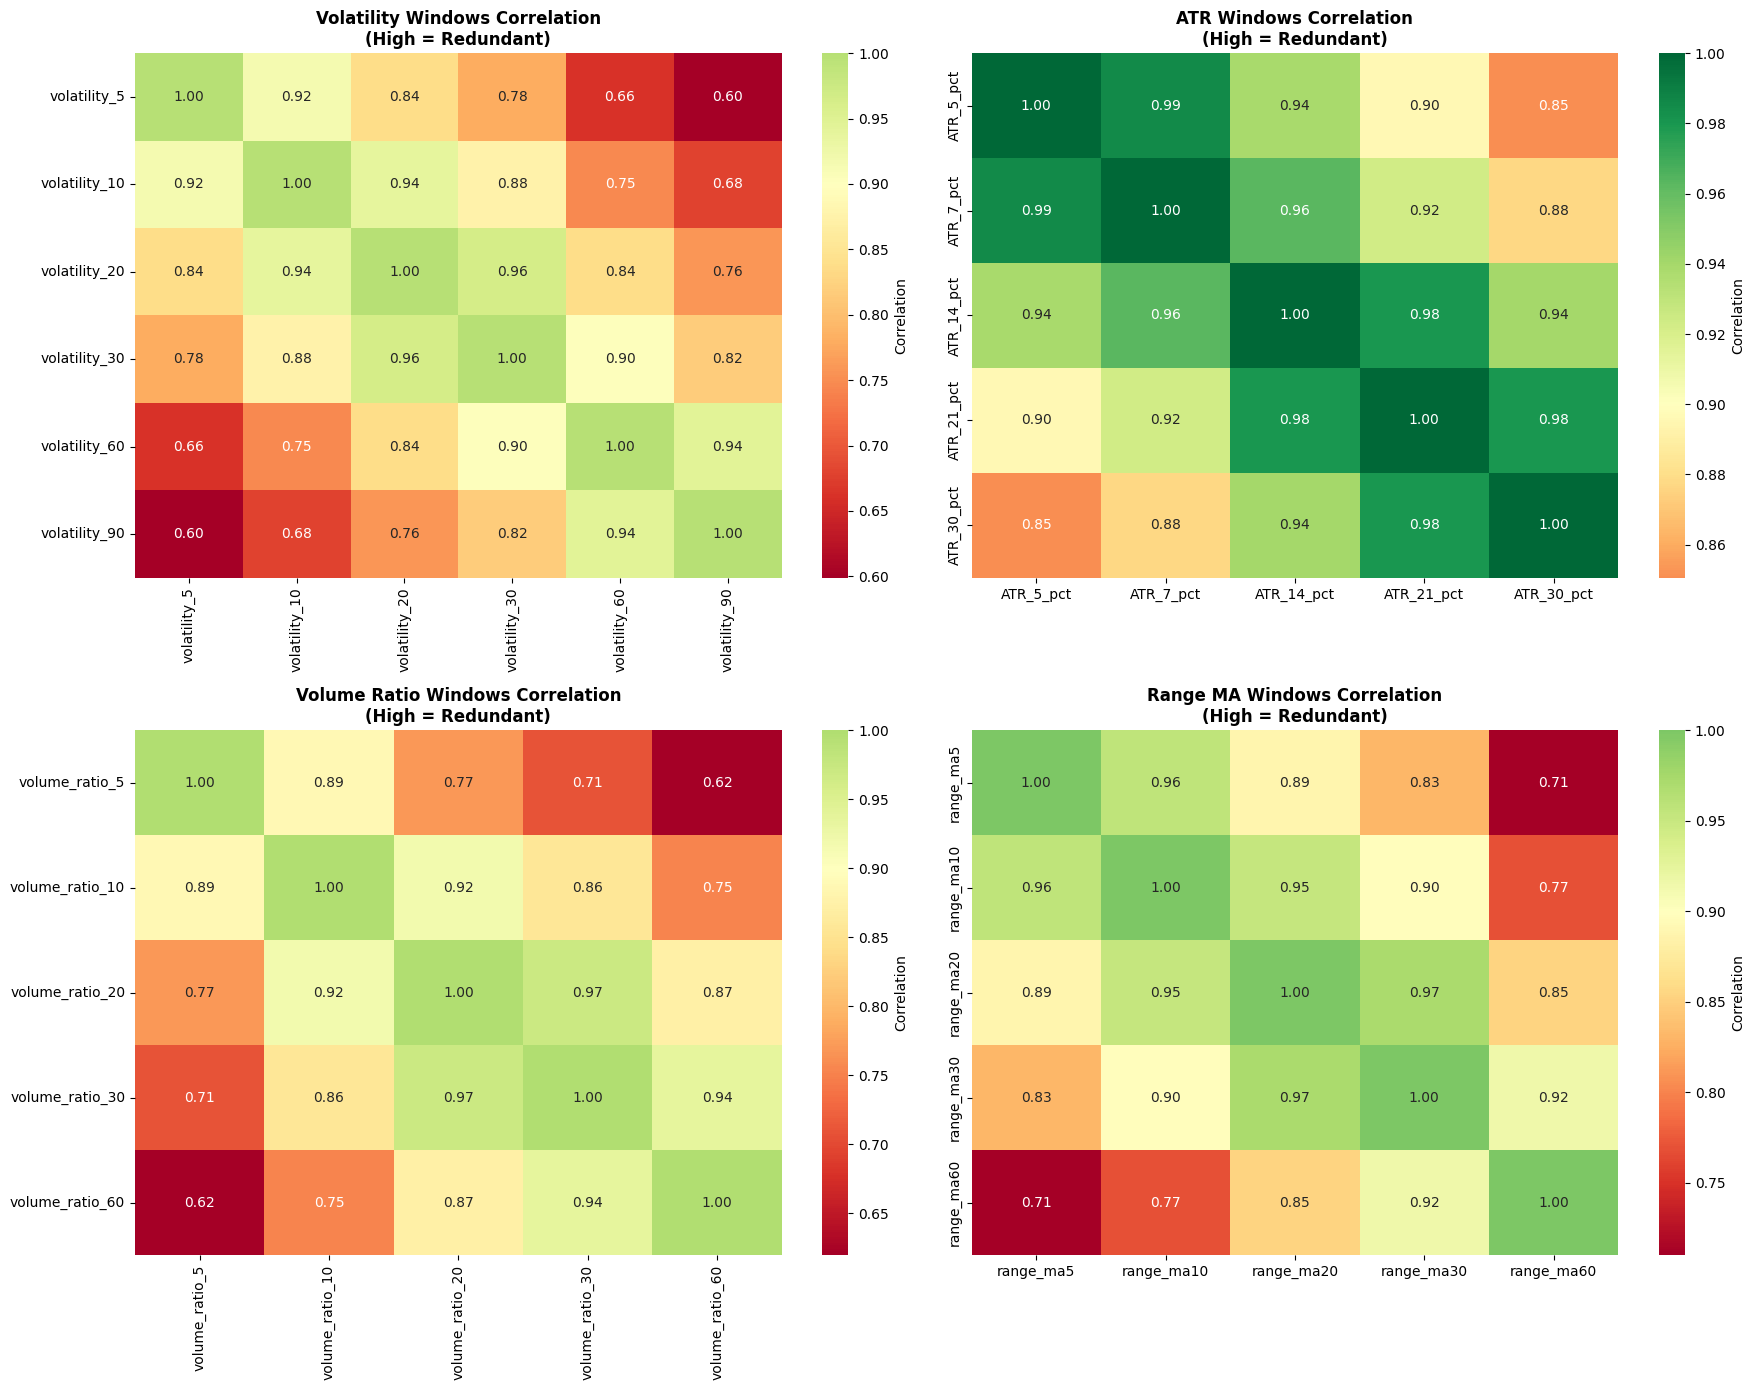


WINDOW ANALYSIS - ALL FEATURES

Key Insights:
• High correlation (>0.95) = windows are redundant, pick one
• Medium correlation (0.80-0.95) = similar but not identical
• Low correlation (<0.80) = windows capture different information

Recommendation for clustering:
• Pick windows with correlation < 0.95 to avoid redundancy
• Example: volatility_20 + ATR_14_pct + volume_ratio_20 + range_ma20
• Or test multiple combinations in hyperparameter optimization



In [6]:
def analyze_volatility_windows(df):

    df_features = add_clustering_features(df)
    
    # Select columns by category
    vol_cols = [col for col in df_features.columns if col.startswith('volatility_')]
    atr_cols = [col for col in df_features.columns if col.startswith('ATR_') and col.endswith('_pct')]
    volume_cols = [col for col in df_features.columns if col.startswith('volume_ratio_')]
    range_cols = ['range_ma5', 'range_ma10', 'range_ma20', 'range_ma30', 'range_ma60']
    
    # Correlation matrices
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # 1. Volatility correlation
    vol_corr = df_features[vol_cols].corr()
    sns.heatmap(vol_corr, annot=True, fmt='.2f', cmap='RdYlGn', center=0.9, 
                ax=axes[0, 0], cbar_kws={'label': 'Correlation'})
    axes[0, 0].set_title('Volatility Windows Correlation\n(High = Redundant)', 
                         fontsize=12, fontweight='bold')
    
    # 2. ATR correlation
    atr_corr = df_features[atr_cols].corr()
    sns.heatmap(atr_corr, annot=True, fmt='.2f', cmap='RdYlGn', center=0.9,
                ax=axes[0, 1], cbar_kws={'label': 'Correlation'})
    axes[0, 1].set_title('ATR Windows Correlation\n(High = Redundant)', 
                         fontsize=12, fontweight='bold')
    
    # 3. Volume ratio correlation
    volume_corr = df_features[volume_cols].corr()
    sns.heatmap(volume_corr, annot=True, fmt='.2f', cmap='RdYlGn', center=0.9,
                ax=axes[1, 0], cbar_kws={'label': 'Correlation'})
    axes[1, 0].set_title('Volume Ratio Windows Correlation\n(High = Redundant)', 
                         fontsize=12, fontweight='bold')
    
    # 4. Range MA correlation
    range_corr = df_features[range_cols].corr()
    sns.heatmap(range_corr, annot=True, fmt='.2f', cmap='RdYlGn', center=0.9,
                ax=axes[1, 1], cbar_kws={'label': 'Correlation'})
    axes[1, 1].set_title('Range MA Windows Correlation\n(High = Redundant)', 
                         fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*70}")
    print(f"WINDOW ANALYSIS - ALL FEATURES")
    print(f"{'='*70}")
    print("\nKey Insights:")
    print(f"• High correlation (>0.95) = windows are redundant, pick one")
    print(f"• Medium correlation (0.80-0.95) = similar but not identical")
    print(f"• Low correlation (<0.80) = windows capture different information")
    print(f"\nRecommendation for clustering:")
    print(f"• Pick windows with correlation < 0.95 to avoid redundancy")
    print(f"• Example: volatility_20 + ATR_14_pct + volume_ratio_20 + range_ma20")
    print(f"• Or test multiple combinations in hyperparameter optimization")
    print(f"{'='*70}\n")

analyze_volatility_windows(spy_train)

In [7]:
def visualize_atr_and_volatility(df, start_date=None, end_date=None):

    df_features = add_clustering_features(df)
    
    # Filter by date if specified
    if start_date:
        df_features = df_features[df_features.index >= start_date]
    if end_date:
        df_features = df_features[df_features.index <= end_date]
    
    fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)
    
    # 1. Price
    ax1 = axes[0]
    ax1.plot(df_features.index, df_features['Adj_Close'], linewidth=1.5, color='black')
    ax1.set_ylabel('SPY Price ($)', fontsize=12)
    ax1.set_title('SPY Price & Volatility Indicators', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # 2. ATR (absolute)
    ax2 = axes[1]
    ax2.plot(df_features.index, df_features['ATR_14'], linewidth=1.5, color='blue', label='ATR (14-day)')
    ax2.fill_between(df_features.index, 0, df_features['ATR_14'], alpha=0.3, color='blue')
    ax2.set_ylabel('ATR ($)', fontsize=12)
    ax2.set_title('Average True Range (Higher = More Volatile)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 3. ATR % (normalized by price)
    ax3 = axes[2]
    ax3.plot(df_features.index, df_features['ATR_14_pct'], linewidth=1.5, color='green', label='ATR %')
    ax3.fill_between(df_features.index, 0, df_features['ATR_14_pct'], alpha=0.3, color='green')
    ax3.set_ylabel('ATR (%)', fontsize=12)
    ax3.set_title('ATR as % of Price (Normalized)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 4. Compare ATR vs Standard Deviation volatility
    ax4 = axes[3]
    ax4.plot(df_features.index, df_features['ATR_14_pct'], linewidth=1.5, 
             color='green', label='ATR % (captures gaps)', alpha=0.7)
    ax4.plot(df_features.index, df_features['volatility_20'], linewidth=1.5, 
             color='red', label='20-day Volatility % (std dev)', alpha=0.7)
    ax4.set_ylabel('Volatility (%)', fontsize=12)
    ax4.set_xlabel('Date', fontsize=12)
    ax4.set_title('ATR vs Traditional Volatility Comparison', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{'='*70}")
    print(f"ATR STATISTICS (14-day window)")
    print(f"{'='*70}")
    print(f"Average ATR: ${df_features['ATR_14'].mean():.2f}")
    print(f"Average ATR %: {df_features['ATR_14_pct'].mean():.2f}%")
    print(f"Max ATR: ${df_features['ATR_14'].max():.2f} (on {df_features['ATR_14'].idxmax().strftime('%Y-%m-%d')})")
    print(f"Min ATR: ${df_features['ATR_14'].min():.2f} (on {df_features['ATR_14'].idxmin().strftime('%Y-%m-%d')})")
    print(f"\nHigh ATR periods (top 10%):")
    high_atr_threshold = df_features['ATR_14_pct'].quantile(0.9)
    print(f"  ATR% > {high_atr_threshold:.2f}%")
    high_atr_count = (df_features['ATR_14_pct'] > high_atr_threshold).sum()
    print(f"  {high_atr_count} days ({high_atr_count/len(df_features)*100:.1f}% of data)")
    print(f"{'='*70}\n")


Visualizing ATR and Volatility on Training Data...


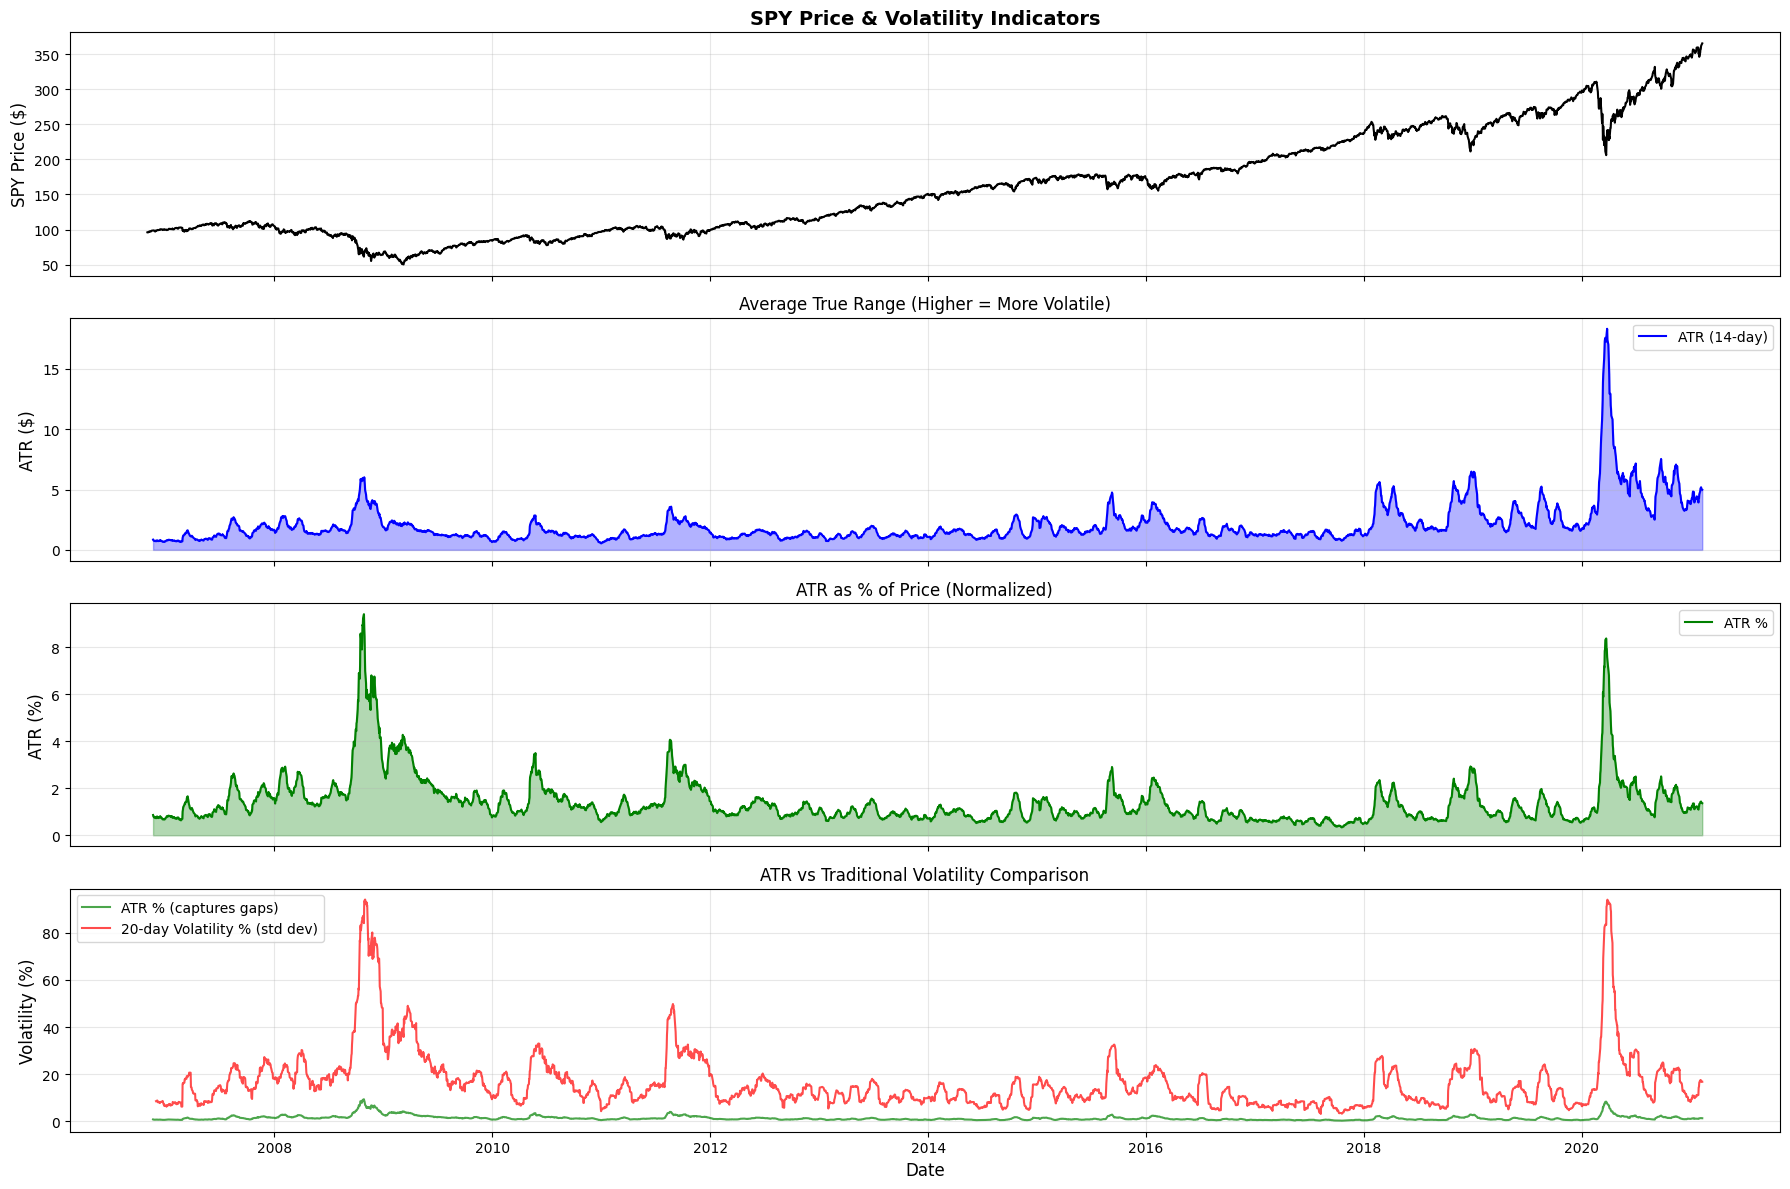


ATR STATISTICS (14-day window)
Average ATR: $2.07
Average ATR %: 1.42%
Max ATR: $18.33 (on 2020-03-26)
Min ATR: $0.54 (on 2010-12-31)

High ATR periods (top 10%):
  ATR% > 2.35%
  358 days (10.0% of data)



In [8]:
# Visualize ATR on full training data
print("\nVisualizing ATR and Volatility on Training Data...")
visualize_atr_and_volatility(spy_train)


Zoom: 2020 COVID Period (High Volatility)...


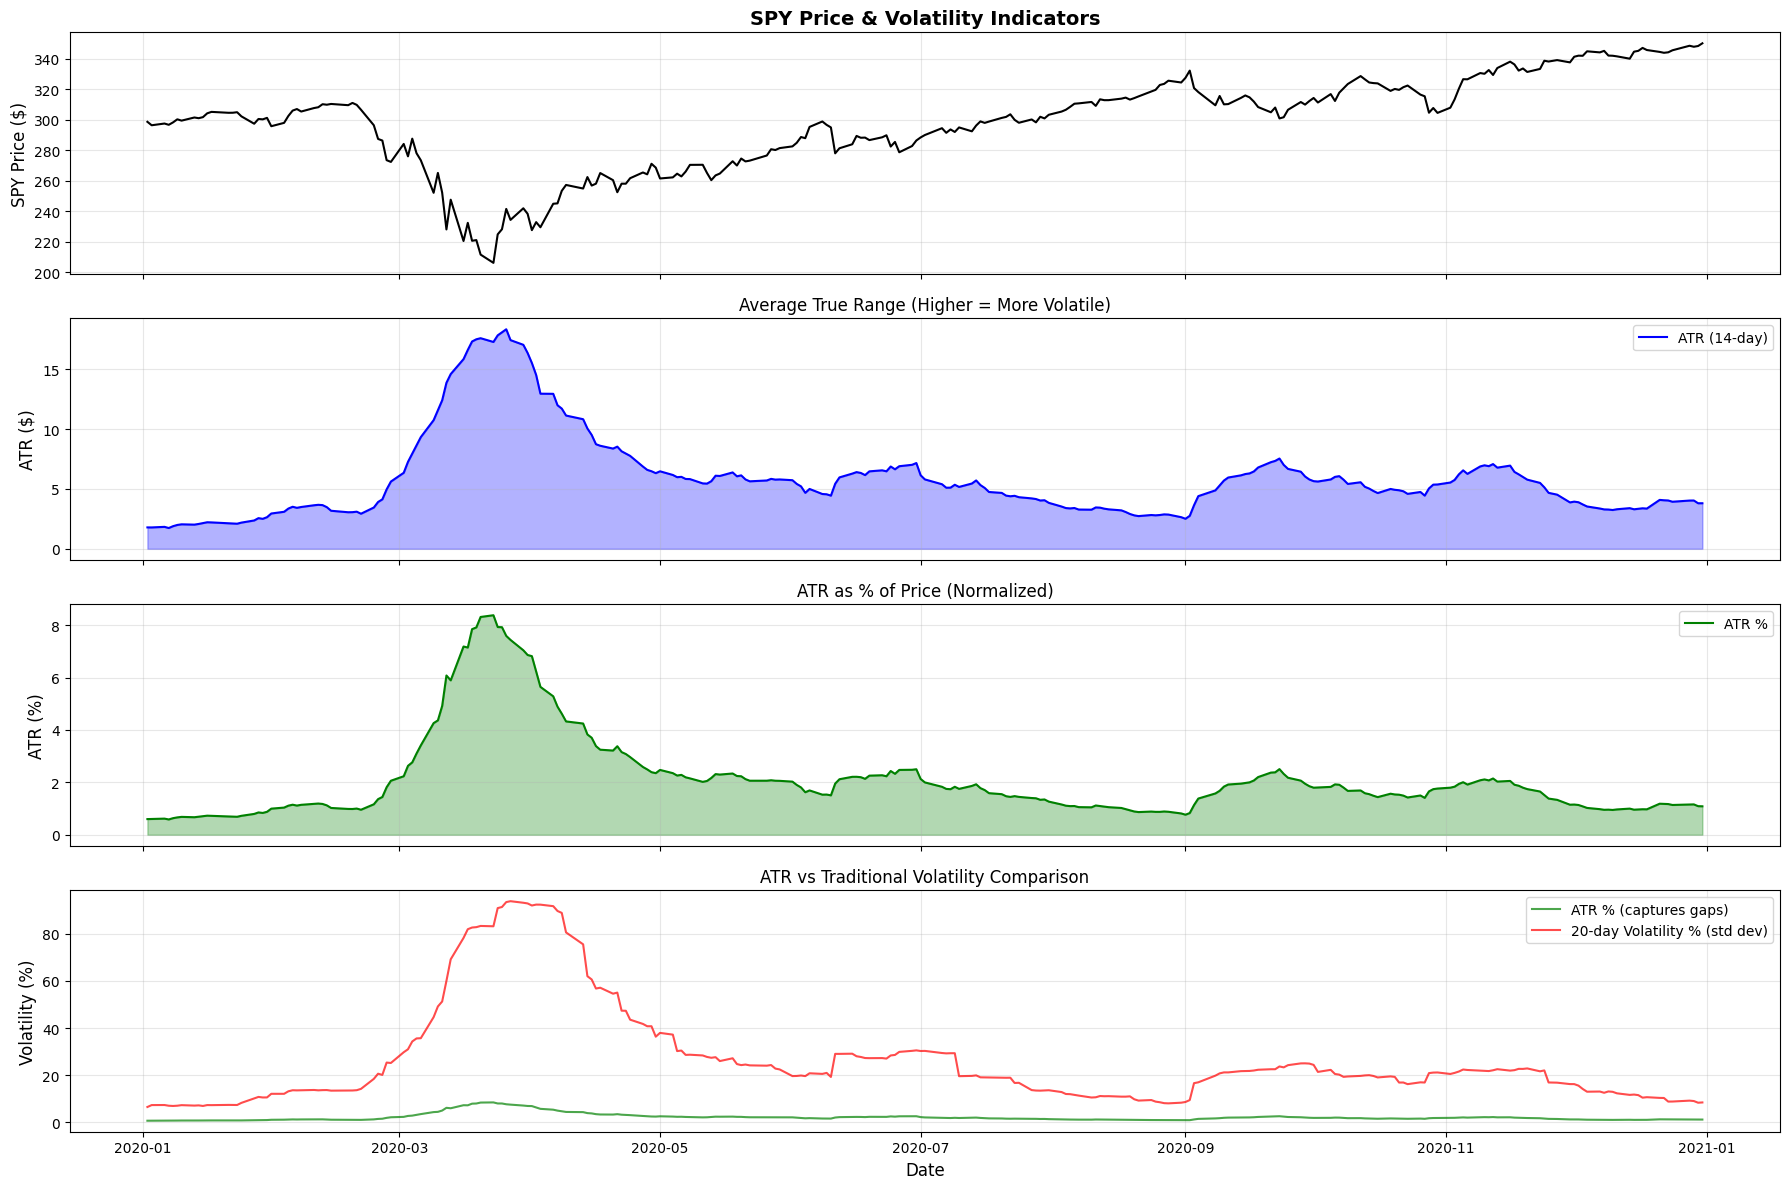


ATR STATISTICS (14-day window)
Average ATR: $5.87
Average ATR %: 2.10%
Max ATR: $18.33 (on 2020-03-26)
Min ATR: $1.74 (on 2020-01-07)

High ATR periods (top 10%):
  ATR% > 3.80%
  26 days (10.3% of data)



In [9]:
# Zoom into 2020 (COVID crash) to see ATR spike
print("\nZoom: 2020 COVID Period (High Volatility)...")
visualize_atr_and_volatility(spy_train, start_date='2020-01-01', end_date='2020-12-31')


Zoom: 2017 (Low Volatility Period)...


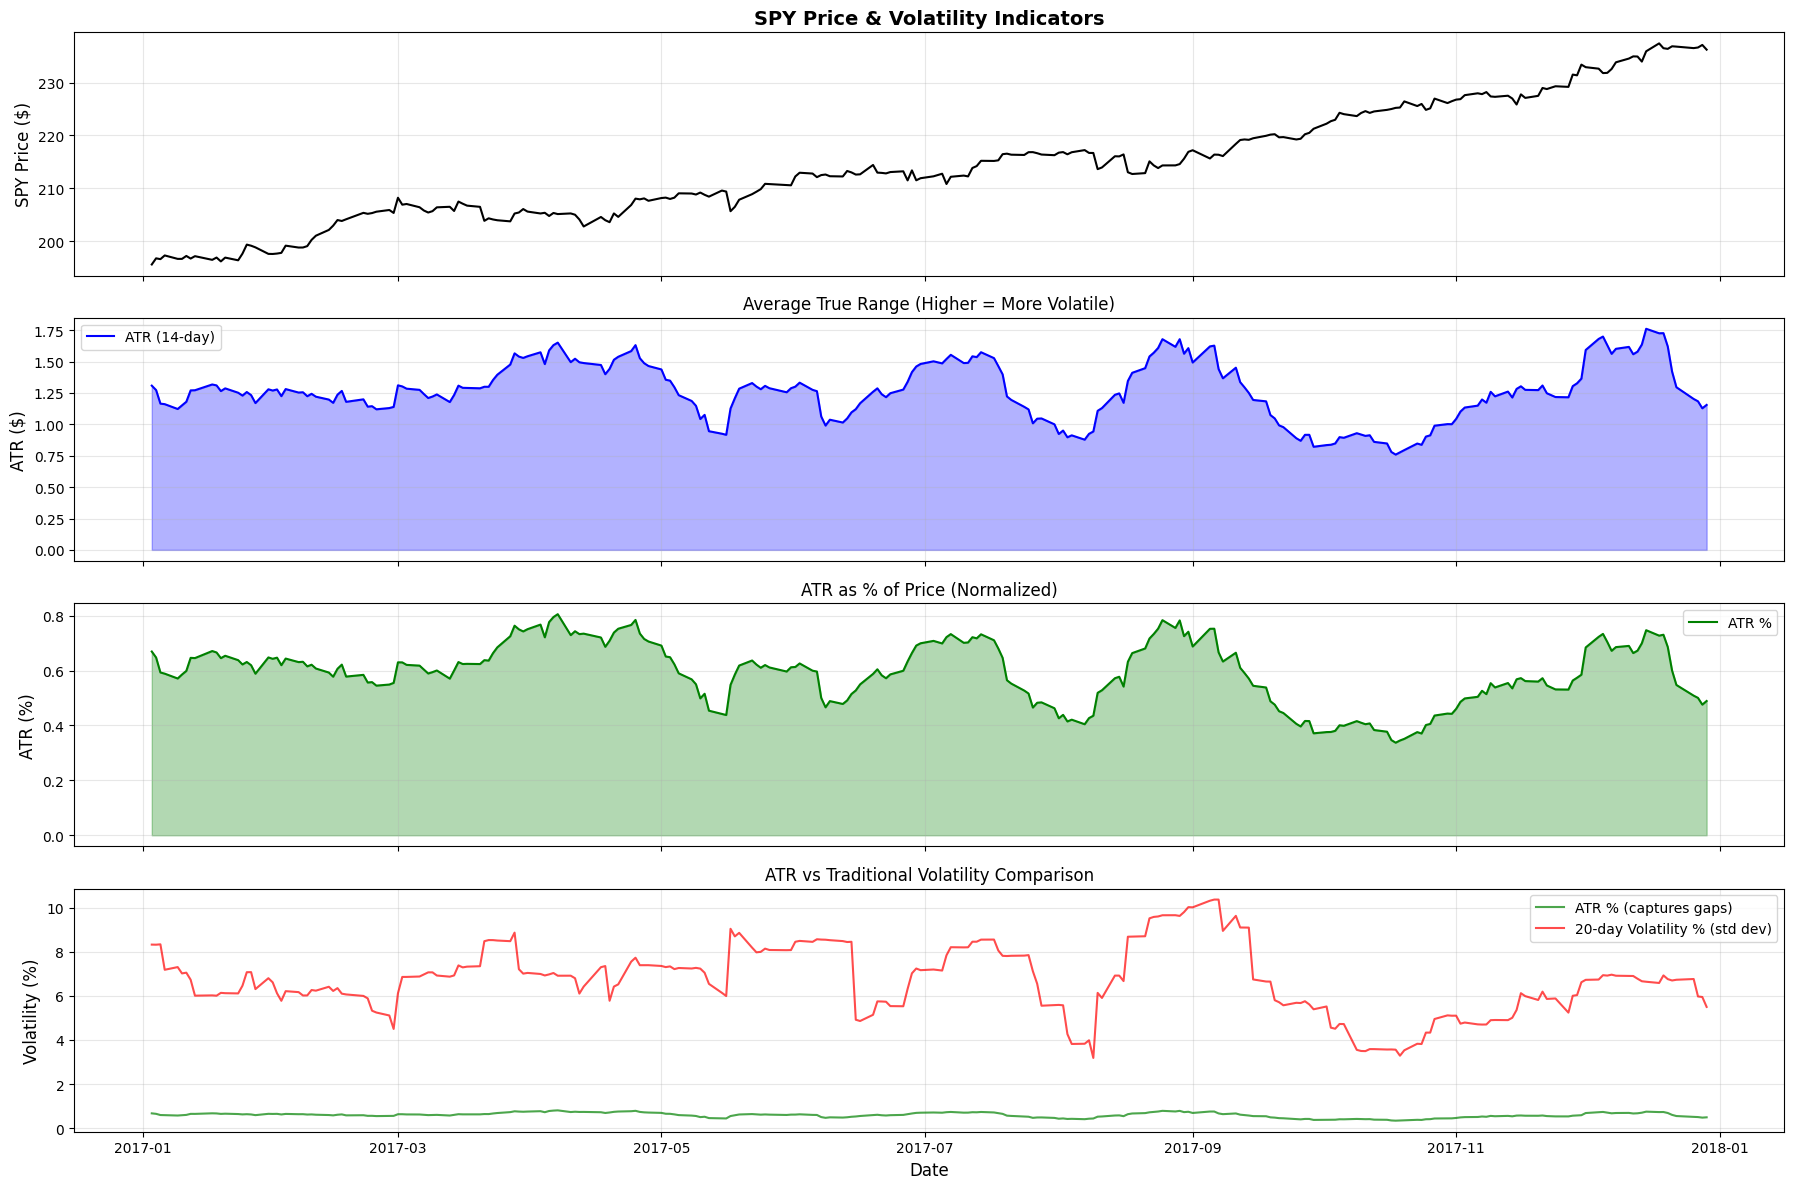


ATR STATISTICS (14-day window)
Average ATR: $1.26
Average ATR %: 0.59%
Max ATR: $1.76 (on 2017-12-15)
Min ATR: $0.76 (on 2017-10-18)

High ATR periods (top 10%):
  ATR% > 0.73%
  25 days (10.0% of data)



In [10]:
# Zoom into 2017 (calm market) to see low ATR
print("\nZoom: 2017 (Low Volatility Period)...")
visualize_atr_and_volatility(spy_train, start_date='2017-01-01', end_date='2017-12-31')

In [11]:
def explore_optimal_clusters(df, max_clusters=5, features_cols=None):
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import silhouette_score, davies_bouldin_score
    
    # Prepare features
    df_features = add_clustering_features(df)
    
    # Select features for clustering
    if features_cols is None:
        # Default: volatility, ATR, volume, and range
        features_cols = ['volatility_20', 'ATR_14_pct', 'volume_ratio_20', 'range_ma20']
    
    features = df_features[features_cols].dropna()
    
    print(f"\nClustering on {len(features)} data points using features: {features_cols}")
    
    # Standardize (critical for K-means)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Test different numbers of clusters
    inertias = []
    silhouette_scores = []
    davies_bouldin_scores = []
    K_range = range(2, max_clusters + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(features_scaled)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(features_scaled, labels))
        davies_bouldin_scores.append(davies_bouldin_score(features_scaled, labels))
        
        print(f"k={k}: Inertia={kmeans.inertia_:.2f}, "
              f"Silhouette={silhouette_score(features_scaled, labels):.3f}, "
              f"Davies-Bouldin={davies_bouldin_score(features_scaled, labels):.3f}")
    
    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Elbow plot
    axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
    axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticks(K_range)
    
    # Silhouette plot (higher is better)
    axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[1].set_ylabel('Silhouette Score', fontsize=12)
    axes[1].set_title('Silhouette Analysis (Higher = Better)', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xticks(K_range)
    axes[1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Good threshold (0.5)')
    axes[1].legend()
    
    # Davies-Bouldin plot (lower is better)
    axes[2].plot(K_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
    axes[2].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[2].set_ylabel('Davies-Bouldin Index', fontsize=12)
    axes[2].set_title('Davies-Bouldin Index (Lower = Better)', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xticks(K_range)
    
    plt.tight_layout()
    plt.show()
    
    # Recommendation
    best_silhouette_k = K_range[np.argmax(silhouette_scores)]
    best_db_k = K_range[np.argmin(davies_bouldin_scores)]
    
    print(f"\n{'='*70}")
    print(f"CLUSTERING RECOMMENDATION")
    print(f"{'='*70}")
    print(f"Best k by Silhouette Score: {best_silhouette_k}")
    print(f"Best k by Davies-Bouldin Index: {best_db_k}")
    print(f"Recommended: k=3 (Low/Medium/High volatility regimes)")
    print(f"{'='*70}\n")
    
    return K_range, inertias, silhouette_scores, davies_bouldin_scores


STEP 0.2: FINDING OPTIMAL NUMBER OF CLUSTERS

--- Test 1: Default Features (Recommended) ---

Clustering on 3571 data points using features: ['volatility_20', 'ATR_14_pct', 'volume_ratio_20', 'range_ma20']
k=2: Inertia=7864.19, Silhouette=0.705, Davies-Bouldin=0.634
k=3: Inertia=5560.69, Silhouette=0.444, Davies-Bouldin=0.818
k=4: Inertia=3756.34, Silhouette=0.438, Davies-Bouldin=0.746
k=5: Inertia=3011.18, Silhouette=0.401, Davies-Bouldin=0.790
k=6: Inertia=2466.08, Silhouette=0.356, Davies-Bouldin=0.827


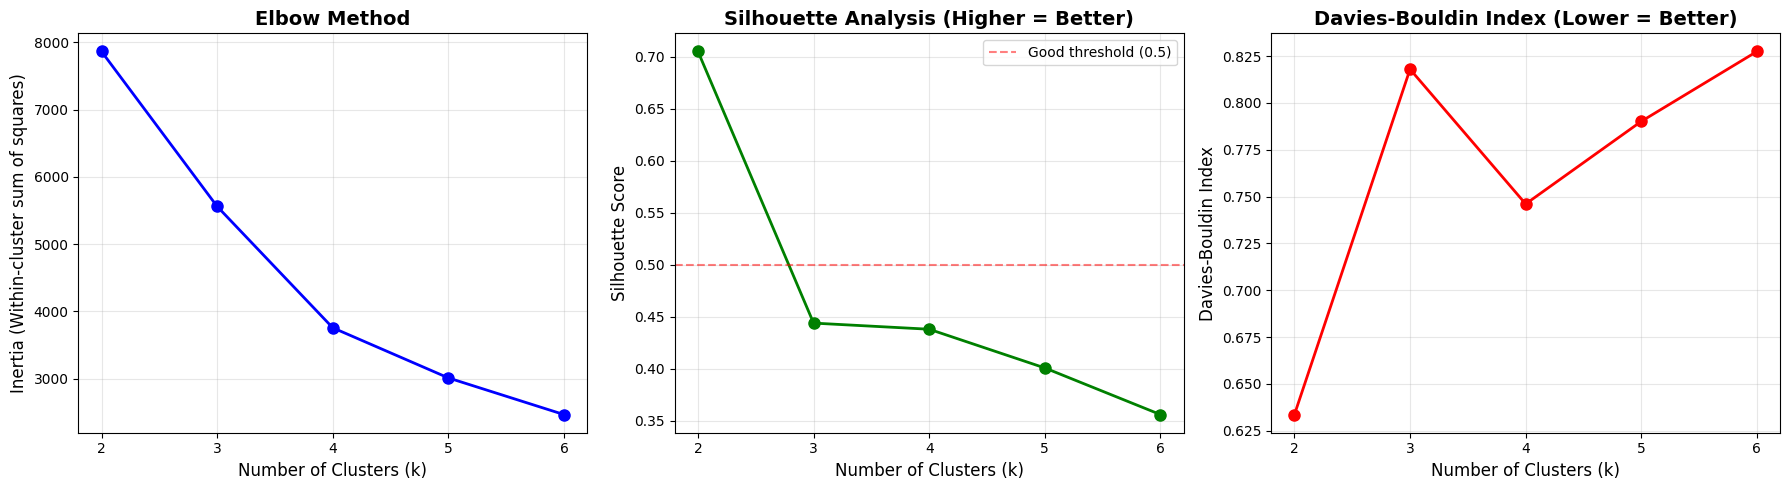


CLUSTERING RECOMMENDATION
Best k by Silhouette Score: 2
Best k by Davies-Bouldin Index: 2
Recommended: k=3 (Low/Medium/High volatility regimes)



In [12]:
# Run the analysis on training data
print("\n" + "="*70)
print("STEP 0.2: FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*70)

# Test 1: Default features (volatility + ATR + volume + range)
print("\n--- Test 1: Default Features (Recommended) ---")
K_range, inertias, silhouette_scores, db_scores = explore_optimal_clusters(
    spy_train, 
    max_clusters=6
)


--- Test 2: Volatility + Volume Only ---

Clustering on 3571 data points using features: ['volatility_20', 'ATR_14_pct', 'volume_ratio_20']
k=2: Inertia=6466.59, Silhouette=0.678, Davies-Bouldin=0.685
k=3: Inertia=4450.21, Silhouette=0.427, Davies-Bouldin=0.863
k=4: Inertia=3038.49, Silhouette=0.435, Davies-Bouldin=0.746
k=5: Inertia=2443.09, Silhouette=0.351, Davies-Bouldin=0.818
k=6: Inertia=2014.00, Silhouette=0.361, Davies-Bouldin=0.828


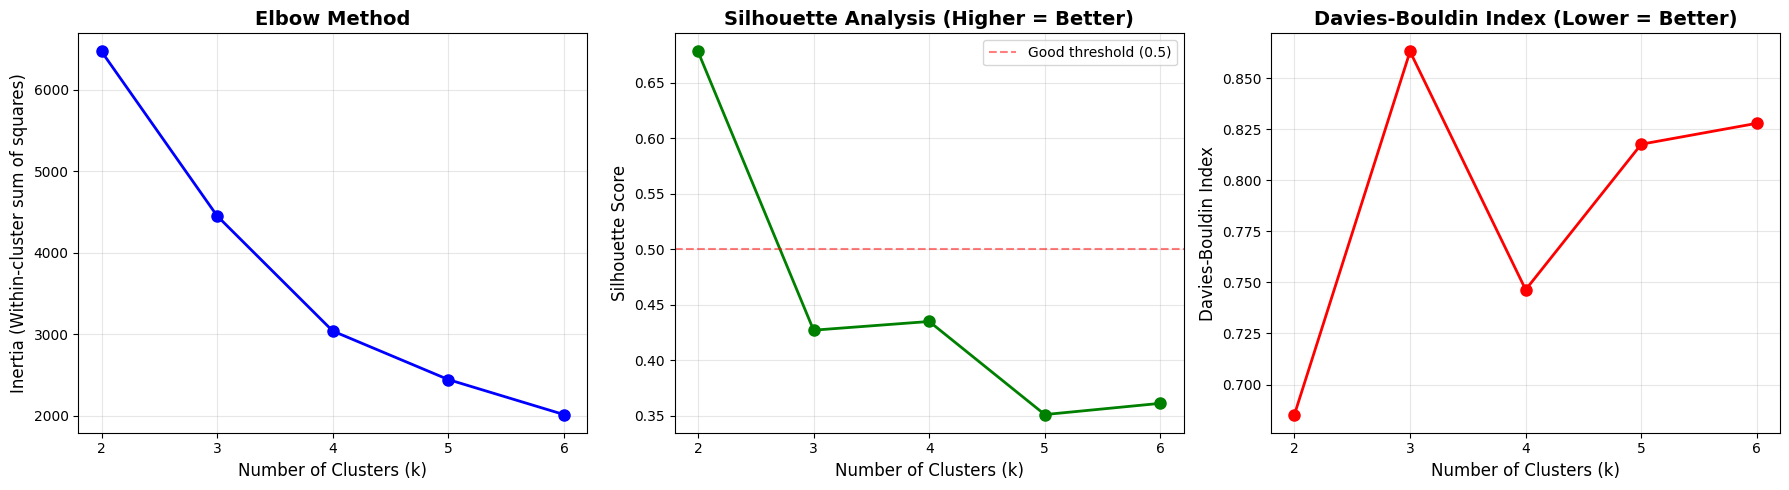


CLUSTERING RECOMMENDATION
Best k by Silhouette Score: 2
Best k by Davies-Bouldin Index: 2
Recommended: k=3 (Low/Medium/High volatility regimes)



In [13]:
# Test 2: Volatility + Volume only (see if volume helps)
print("\n--- Test 2: Volatility + Volume Only ---")
K_range2, inertias2, silhouette2, db2 = explore_optimal_clusters(
    spy_train,
    max_clusters=6,
    features_cols=['volatility_20', 'ATR_14_pct', 'volume_ratio_20']
)


--- Test 3: Multi-Window Features ---

Clustering on 3531 data points using features: ['volatility_5', 'volatility_20', 'volatility_60', 'ATR_14_pct', 'volume_ratio_5', 'volume_ratio_20']
k=2: Inertia=13511.25, Silhouette=0.617, Davies-Bouldin=0.854
k=3: Inertia=9946.53, Silhouette=0.345, Davies-Bouldin=1.029
k=4: Inertia=7760.67, Silhouette=0.357, Davies-Bouldin=0.944
k=5: Inertia=6635.76, Silhouette=0.271, Davies-Bouldin=1.063
k=6: Inertia=5715.38, Silhouette=0.273, Davies-Bouldin=1.046


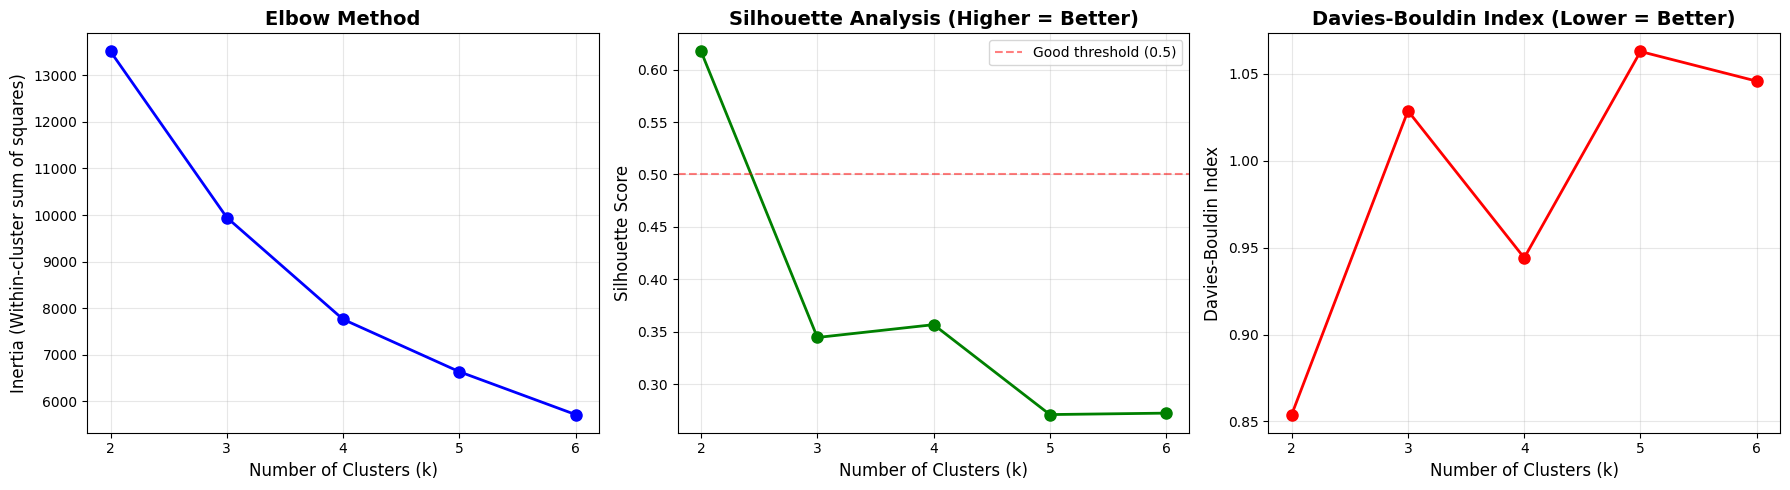


CLUSTERING RECOMMENDATION
Best k by Silhouette Score: 2
Best k by Davies-Bouldin Index: 2
Recommended: k=3 (Low/Medium/High volatility regimes)



In [14]:
# Test 3: Multi-window features (capture different timeframes)
print("\n--- Test 3: Multi-Window Features ---")
K_range3, inertias3, silhouette3, db3 = explore_optimal_clusters(
    spy_train,
    max_clusters=6,
    features_cols=['volatility_5', 'volatility_20', 'volatility_60', 
                   'ATR_14_pct', 'volume_ratio_5', 'volume_ratio_20']
)


--- Test 3: Multi-Window Features ---

Clustering on 3571 data points using features: ['volatility_5', 'volatility_20', 'ATR_14_pct', 'volume_ratio_5', 'volume_ratio_20']
k=2: Inertia=11949.16, Silhouette=0.634, Davies-Bouldin=0.798
k=3: Inertia=8306.50, Silhouette=0.368, Davies-Bouldin=0.975
k=4: Inertia=6402.61, Silhouette=0.358, Davies-Bouldin=0.924
k=5: Inertia=5292.95, Silhouette=0.302, Davies-Bouldin=0.950
k=6: Inertia=4695.36, Silhouette=0.297, Davies-Bouldin=0.989


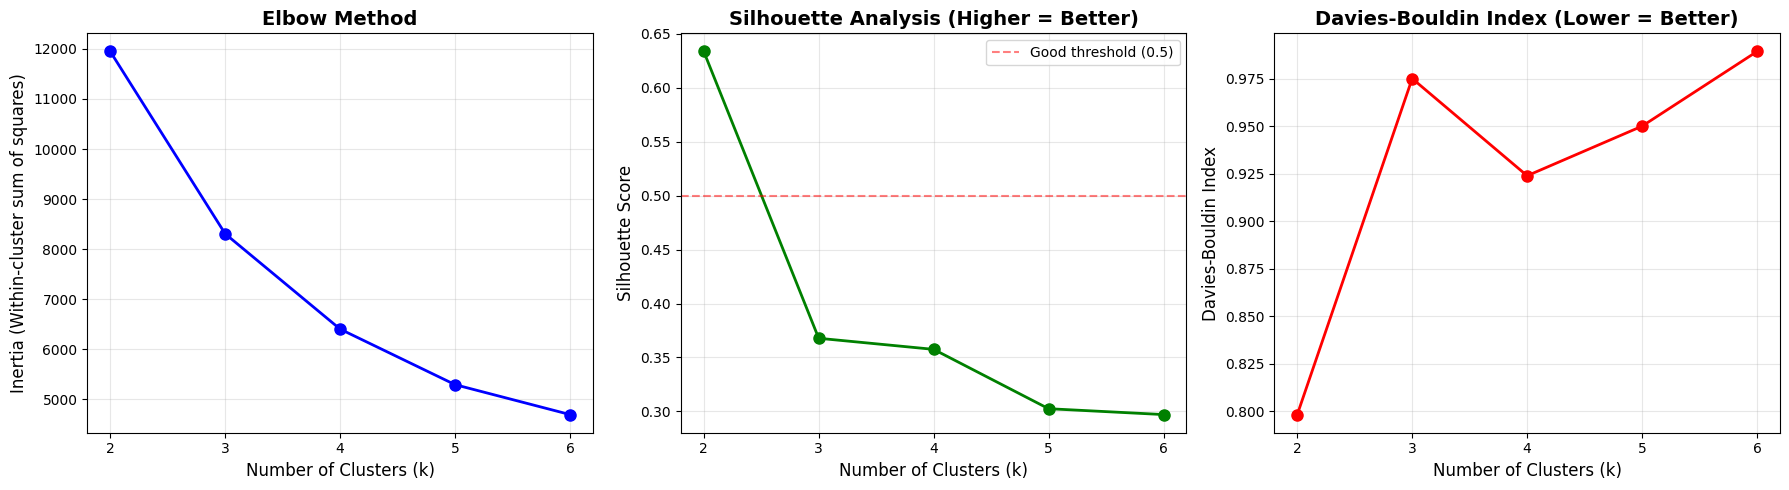


CLUSTERING RECOMMENDATION
Best k by Silhouette Score: 2
Best k by Davies-Bouldin Index: 2
Recommended: k=3 (Low/Medium/High volatility regimes)



In [15]:
# Test 3: Multi-window features (capture different timeframes)
print("\n--- Test 3: Multi-Window Features ---")
K_range3, inertias3, silhouette3, db3 = explore_optimal_clusters(
    spy_train,
    max_clusters=6,
    features_cols=['volatility_5', 'volatility_20',
                   'ATR_14_pct', 'volume_ratio_5', 'volume_ratio_20']
)

In [16]:
# Compare results
print("\n" + "="*70)
print("COMPARISON: Which Features Give Best Clusters?")
print("="*70)
print(f"{'Feature Set':<40} {'Best k (Silh)':>15} {'Best Silh Score':>15}")
print("-"*70)
print(f"{'1. Default (vol+ATR+volume+range)':<40} {K_range[np.argmax(silhouette_scores)]:>15} {max(silhouette_scores):>15.3f}")
print(f"{'2. Volatility + Volume':<40} {K_range2[np.argmax(silhouette2)]:>15} {max(silhouette2):>15.3f}")
print(f"{'3. Multi-Window':<40} {K_range3[np.argmax(silhouette3)]:>15} {max(silhouette3):>15.3f}")
print("="*70)
print("\nRecommendation: Use feature set with highest silhouette score")
print("="*70 + "\n")


COMPARISON: Which Features Give Best Clusters?
Feature Set                                Best k (Silh) Best Silh Score
----------------------------------------------------------------------
1. Default (vol+ATR+volume+range)                      2           0.705
2. Volatility + Volume                                 2           0.678
3. Multi-Window                                        2           0.634

Recommendation: Use feature set with highest silhouette score



In [17]:
def visualize_regimes(df, n_clusters=2, features_cols=None):
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Add features and cluster
    df_features = add_clustering_features(df)
    
    if features_cols is None:
        features_cols = ['volatility_20', 'ATR_14_pct', 'volume_ratio_20', 'range_ma20']
    
    features = df_features[features_cols].dropna()
    
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df_features.loc[features.index, 'regime'] = kmeans.fit_predict(features_scaled)
    
    # Sort regimes by volatility (0=Low, 1=High for n=2)
    regime_volatility = df_features.groupby('regime')['volatility_20'].mean().sort_values()
    regime_mapping = {old: new for new, old in enumerate(regime_volatility.index)}
    df_features['regime'] = df_features['regime'].map(regime_mapping)
    
    if n_clusters == 2:
        regime_names = {0: 'Low Vol', 1: 'High Vol'}
    elif n_clusters == 3:
        regime_names = {0: 'Low Vol', 1: 'Med Vol', 2: 'High Vol'}
    else:
        regime_names = {i: f'Regime {i}' for i in range(n_clusters)}
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Regime characteristics
    ax1 = axes[0, 0]
    regime_stats = df_features.groupby('regime')[features_cols].mean()
    regime_stats.plot(kind='bar', ax=ax1)
    ax1.set_title('Average Feature Values by Regime', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Regime')
    ax1.set_xticklabels([regime_names[i] for i in regime_stats.index], rotation=0)
    ax1.legend(loc='best', fontsize=8)
    ax1.grid(alpha=0.3)
    
    # 2. Regime timeline with price
    ax2 = axes[0, 1]
    ax2.plot(df_features.index, df_features['Adj_Close'], alpha=0.5, label='SPY Price', linewidth=1)
    ax2_twin = ax2.twinx()
    colors = {0: 'green', 1: 'red', 2: 'orange'}
    for regime in sorted(df_features['regime'].dropna().unique()):
        mask = df_features['regime'] == regime
        ax2_twin.scatter(df_features[mask].index, [regime]*mask.sum(), 
                       c=colors.get(int(regime), 'gray'), alpha=0.3, s=1, 
                       label=regime_names[int(regime)])
    ax2.set_title('Regime Timeline', fontsize=12, fontweight='bold')
    ax2.set_ylabel('SPY Price', fontsize=10)
    ax2_twin.set_ylabel('Regime', fontsize=10)
    ax2_twin.set_yticks(list(range(n_clusters)))
    ax2_twin.set_yticklabels([regime_names[i] for i in range(n_clusters)])
    ax2.legend(loc='upper left', fontsize=8)
    ax2_twin.legend(loc='upper right', fontsize=8)
    
    # 3. Volatility distribution by regime
    ax3 = axes[0, 2]
    df_features.boxplot(column='volatility_20', by='regime', ax=ax3)
    ax3.set_title('Volatility Distribution by Regime', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Regime', fontsize=10)
    ax3.set_ylabel('20-Day Volatility (%)', fontsize=10)
    plt.sca(ax3)
    plt.xticks(range(1, n_clusters+1), [regime_names[i] for i in range(n_clusters)])
    
    # 4. Volume distribution by regime
    ax4 = axes[1, 0]
    df_features.boxplot(column='volume_ratio_20', by='regime', ax=ax4)
    ax4.set_title('Volume Ratio Distribution by Regime', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Regime', fontsize=10)
    ax4.set_ylabel('Volume Ratio', fontsize=10)
    plt.sca(ax4)
    plt.xticks(range(1, n_clusters+1), [regime_names[i] for i in range(n_clusters)])
    
    # 5. Regime transitions / duration
    ax5 = axes[1, 1]
    regime_duration = []
    current_regime = None
    duration = 0
    for regime in df_features['regime'].dropna():
        if regime == current_regime:
            duration += 1
        else:
            if current_regime is not None:
                regime_duration.append({'regime': int(current_regime), 'duration': duration})
            current_regime = regime
            duration = 1
    
    regime_duration_df = pd.DataFrame(regime_duration)
    if len(regime_duration_df) > 0:
        regime_duration_df.boxplot(column='duration', by='regime', ax=ax5)
        ax5.set_title('Regime Duration Distribution (days)', fontsize=12, fontweight='bold')
        ax5.set_xlabel('Regime', fontsize=10)
        ax5.set_ylabel('Duration (days)', fontsize=10)
        plt.sca(ax5)
        plt.xticks(range(1, n_clusters+1), [regime_names[i] for i in range(n_clusters)])
    
    # 6. Regime frequency pie chart
    ax6 = axes[1, 2]
    regime_counts = df_features['regime'].value_counts().sort_index()
    colors_pie = [colors.get(i, 'gray') for i in regime_counts.index]
    ax6.pie(regime_counts.values, labels=[regime_names[int(i)] for i in regime_counts.index], 
            autopct='%1.1f%%', colors=colors_pie, startangle=90)
    ax6.set_title('Regime Frequency', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{'='*70}")
    print(f"REGIME CLUSTERING ANALYSIS (k={n_clusters})")
    print(f"{'='*70}")
    for regime in sorted(df_features['regime'].dropna().unique()):
        regime_data = df_features[df_features['regime'] == regime]
        pct = len(regime_data) / len(df_features.dropna()) * 100
        print(f"\n{regime_names[int(regime)]} Regime:")
        print(f"  Frequency: {len(regime_data)} days ({pct:.1f}%)")
        print(f"  Avg Volatility: {regime_data['volatility_20'].mean():.2f}%")
        print(f"  Avg ATR: {regime_data['ATR_14_pct'].mean():.2f}%")
        print(f"  Avg Volume Ratio: {regime_data['volume_ratio_20'].mean():.2f}")
        print(f"  Avg Daily Range: {regime_data['high_low_range'].mean():.2f}%")
    print(f"{'='*70}\n")
    
    return df_features


STEP 0.3: VISUALIZING THE 2 REGIMES


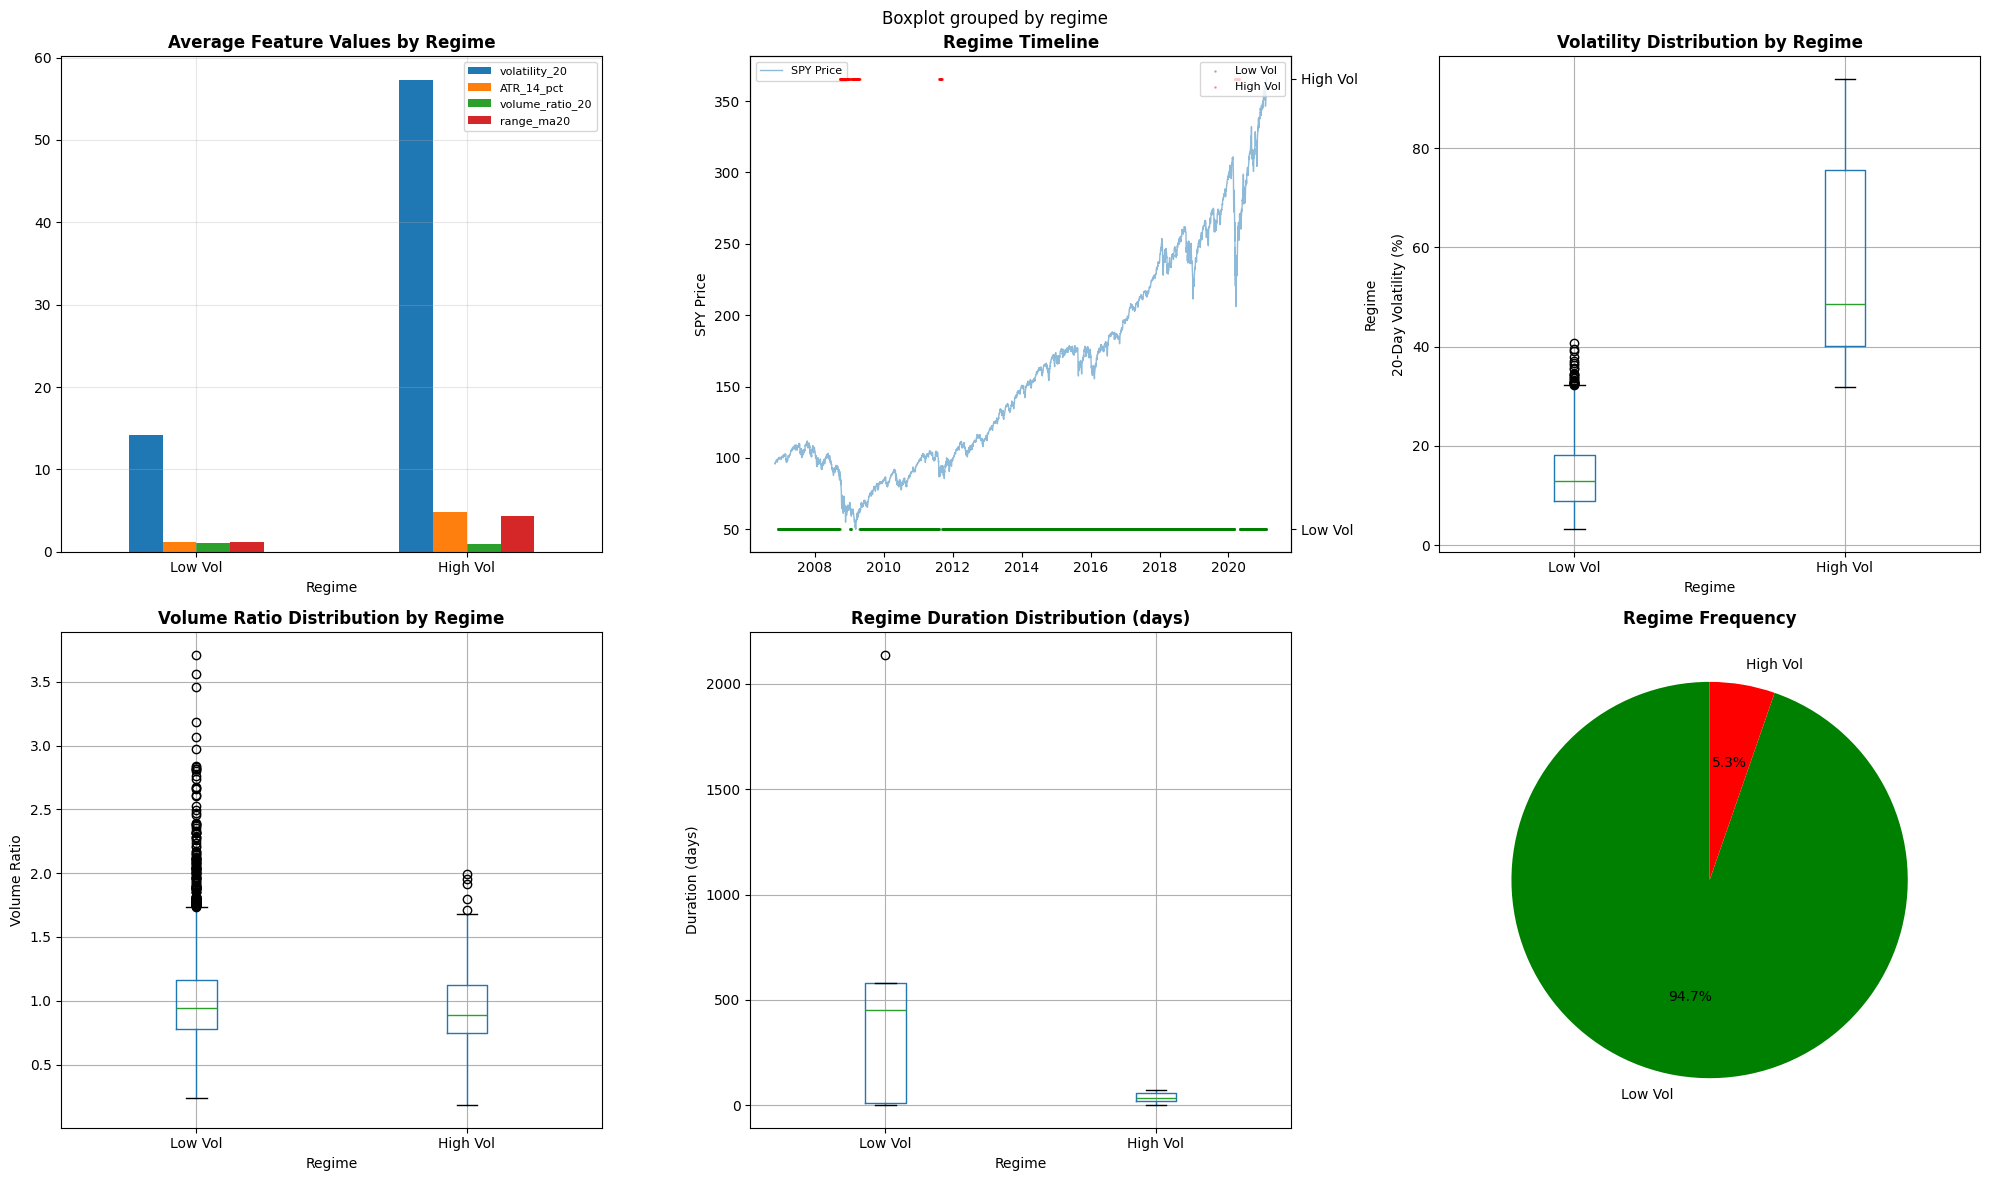


REGIME CLUSTERING ANALYSIS (k=2)

Low Vol Regime:
  Frequency: 3381 days (96.6%)
  Avg Volatility: 14.18%
  Avg ATR: 1.23%
  Avg Volume Ratio: 1.01
  Avg Daily Range: 1.13%

High Vol Regime:
  Frequency: 190 days (5.4%)
  Avg Volatility: 57.29%
  Avg ATR: 4.78%
  Avg Volume Ratio: 0.94
  Avg Daily Range: 4.19%



In [18]:
# Visualize the 2 regimes
print("\n" + "="*70)
print("STEP 0.3: VISUALIZING THE 2 REGIMES")
print("="*70)
spy_train_with_regimes = visualize_regimes(spy_train, n_clusters=2)